# Task 2


In [1]:
!pip install wandb
!pip install torch_geometric
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=4ce16d59e1733742840a37b3f1a01c3b855fcb6d34364d87a5015ff6ae59b8ba
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 54.2 MB/s eta 0:00:00


In [2]:
import random
import wandb
from tqdm import tqdm
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import plotly.express as px


import torch

print(torch.__version__)
print(torch.version.cuda)

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv



import collections
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import plotly.express as px

import seaborn as sns
from functools import partial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


import collections
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

2.1.0+cu118
11.8


## Load a dataset

We use the CiteSeer citation network dataset
The original paper with results on the dataset: https://arxiv.org/pdf/1603.08861.pdf

The image below shows some performance metrics from the paper. Upper sections
shows inductive methods, the lower section shows transductive methods.

![Planetoid Performance Table](planetoid-performance-table.png)

# 2.1 Data Exploration

In [3]:
dataset = Planetoid(name='Cora', split='public', root='data/Cora')
data = dataset[0]  # Get the first (and only) graph object.

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of features per node: {data.num_features}')

G = to_networkx(data, to_undirected=True)
largest_cc = max(nx.connected_components(G), key=len)
diameter = nx.diameter(G.subgraph(largest_cc))
print(f"Diameter: largest nr of edges to travel: {diameter}")

print(data)
print('==============================================================')






Processing...
Done!


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Average node degree: 3.90
Number of features per node: 1433
Diameter: largest nr of edges to travel: 19
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


<ipython-input-4-d7bfcdf96de5>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), fontsize=10)  # Set ytick font size consistently


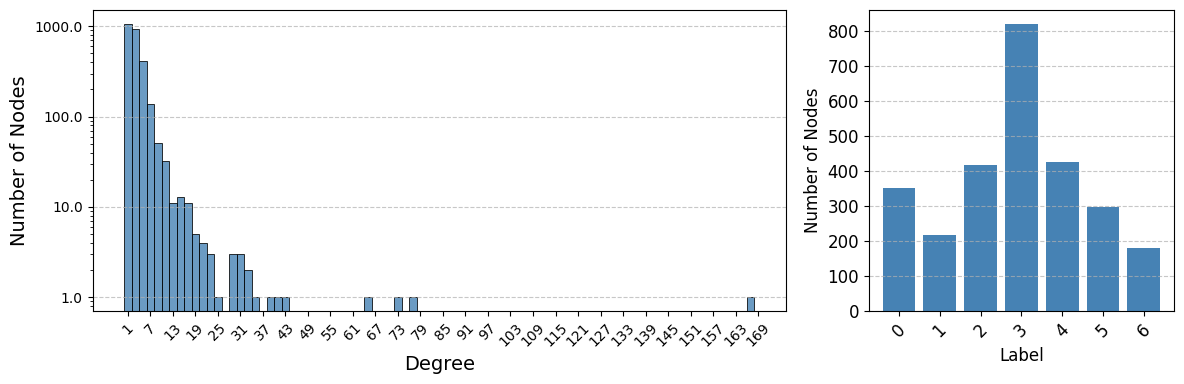

In [4]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

# Distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
node_labels = dataset[0].y.tolist()

# Set up the GridSpec layout
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)  # 1 row, 3 columns
mpl.rcParams['font.size'] = 12

# Distribution of Node Labels
label_count = collections.Counter(node_labels)
labels, counts = zip(*label_count.items())

ax1 = plt.subplot(gs[0, 2])  # Use the third column for this plot
ax1.bar(labels, counts, color='steelblue')
ax1.set_xlabel("Label")
ax1.set_ylabel("Number of Nodes")
ax1.set_xticks(labels)
ax1.set_xticklabels(labels, rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)



# New binning code for Node Degree Distribution
bin_width = 2
bins = np.arange(1, max(degree_sequence) + bin_width, bin_width)  # dynamically create bins based on max degree
hist, bin_edges = np.histogram(degree_sequence, bins=bins)

ax2 = plt.subplot(gs[0, :2])  # Take the first two columns for this plot
ax2.bar(bin_edges[:-1], hist, width=bin_width, color='steelblue', edgecolor='black', linewidth=0.7, alpha=0.8)  # Adjusted edgecolor, linewidth, and alpha
ax2.set_xlabel("Degree", fontsize=14)
ax2.set_ylabel("Number of Nodes", fontsize=14)
ax2.set_yscale('log')

ax2.set_xticks(bin_edges[::3])
ax2.set_xticklabels(bin_edges[::3], rotation=45, fontsize=10)  # Adjust the font size here
ax2.set_yticklabels(ax2.get_yticks(), fontsize=10)  # Set ytick font size consistently
ax2.tick_params(axis='x', labelsize=10)  # Set xtick font size consistently
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# 2.2 Label Propagation with full observations (5 Points)

In [5]:
def predict_label(node, graph, labels):

    # Get labels of neighbors
    neighbors = list(graph.neighbors(node))
    if not neighbors:
        return labels[node]
    neighbor_labels = [labels[neighbor] for neighbor in neighbors]

    # Get label with max occurency
    label_counts = collections.Counter(neighbor_labels)
    max_count = max(label_counts.values())

    # Figure out label(s) with highest occurence
    majority_labels = []
    for label, count in label_counts.items():
        if count == max_count:
            majority_labels.append(label)

    # Return majority label, else random sampling
    if len(majority_labels) == 1:
        return majority_labels[0]
    else:
        return random.choice(majority_labels)


def evaluate_neighbours_with_seeds(G, nodes_to_predict, true_labels, node_labels, seeds):
    accuracies = []
    for seed in seeds:
        random.seed(seed)
        predicted_labels = [predict_label(node, G, node_labels) for node in nodes_to_predict]
        accuracy = accuracy_score(true_labels, predicted_labels)
        accuracies.append(accuracy)
        print(f"Seed {seed} - Accuracy: {accuracy:.4f}")
    return np.mean(accuracies), np.std(accuracies)



test_nodes = [node for node, mask in enumerate(data.test_mask) if mask]

test_true_labels = data.y[test_nodes].numpy()
node_labels = data.y.numpy()

seeds=[42, 43, 44]
mean_accuracy, std_dev = evaluate_neighbours_with_seeds(G, test_nodes, test_true_labels, node_labels, seeds)
print(f"Full Observation - Mean Accuracy: {mean_accuracy:.4f} ± {std_dev:.4f}")


Seed 42 - Accuracy: 0.8610
Seed 43 - Accuracy: 0.8600
Seed 44 - Accuracy: 0.8630
Full Observation - Mean Accuracy: 0.8613 ± 0.0012


# 2.3 Baseline without Graph Structure (5 Points)

In [6]:

def evaluate_with_seeds(model_class, seeds, X, y, train_mask, val_mask, test_mask, hyperparams=None, **model_kwargs):
    accuracies = []

    if hyperparams is None:
        hyperparams = {'n_estimators': [500, 1500, 2000]}

    overall_best_params = {}
    best_overall_val_acc = 0

    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)

        X_train = X[train_mask].numpy()
        y_train = y[train_mask].numpy()

        X_val = X[val_mask].numpy()
        y_val = y[val_mask].numpy()

        X_test = X[test_mask].numpy()
        y_test = y[test_mask].numpy()

        # Hyperparameter tuning using validation set
        best_val_acc = 0
        best_seed_params = {}
        for param, values in hyperparams.items():
            for value in values:
                model_kwargs[param] = value
                clf = model_class(random_state=seed, **model_kwargs)
                clf.fit(X_train, y_train)
                val_pred = clf.predict(X_val)
                val_accuracy = accuracy_score(y_val, val_pred)

                if val_accuracy > best_val_acc:
                    best_val_acc = val_accuracy
                    best_seed_params[param] = value

        # If this seed's best validation accuracy is better than previous, update overall best params
        if best_val_acc > best_overall_val_acc:
            best_overall_val_acc = best_val_acc
            overall_best_params = best_seed_params

        # Training model using best params for this seed
        clf = model_class(random_state=seed, **best_seed_params)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        # Print the accuracy for this seed
        print(f"Seed {seed} - Accuracy: {accuracy:.4f}")

    mean_accuracy = np.mean(accuracies)
    std_deviation = np.std(accuracies)

    return mean_accuracy, std_deviation, overall_best_params


data = dataset[0]
seeds = [42, 43, 44]

mean_acc, std_dev, best_params  = evaluate_with_seeds(RandomForestClassifier, seeds, data.x, data.y, data.train_mask, data.val_mask ,data.test_mask,  n_estimators=100)
print(f"Raw Features - Mean Accuracy: {mean_acc:.4f} ± {std_dev:.4f}")
print(f"Best Parameters: {best_params}")


Seed 42 - Accuracy: 0.5880
Seed 43 - Accuracy: 0.5770
Seed 44 - Accuracy: 0.5850
Raw Features - Mean Accuracy: 0.5833 ± 0.0046
Best Parameters: {'n_estimators': 1500}


# 2.4 Untrained GNNs (8 Points)


In [7]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes):
        super(GNNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [8]:
class MLPEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPEncoder, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [9]:
# Load Data
data = Planetoid(name='Cora', split='public', root='data/Cora')
data = data[0]

# Define Model Parameters
input_dim = data.num_features
hidden_dim = 128 #128
output_dim = 64 #64
num_classes = 7

# Instantiate Embeddings
encoder_GNN = GNNEncoder(input_dim, hidden_dim, output_dim, num_classes)
embeddings_gnn = encoder_GNN(data.x, data.edge_index)

encoder_mlp = MLPEncoder(input_dim, hidden_dim, output_dim)
embeddings_mlp = encoder_mlp(data.x)

random_embeddings = torch.rand(embeddings_mlp.size())

#### Visualize Embeddings

In [12]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go


def get_scatter_trace(embeddings, labels, show_colorbar=True):
    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings.detach().cpu().numpy())
    df = pd.DataFrame(embeddings_2d, columns=["Dim 1", "Dim 2"])
    df['Label'] = labels.cpu().numpy()

    scatter = go.Scatter(x=df["Dim 1"], y=df["Dim 2"], mode="markers",
                         marker=dict(size=5, color=df["Label"], colorscale="jet", showscale=show_colorbar),
                         showlegend=False)  # Disables individual trace legends
    return scatter, df

# Generate scatter traces and dataframes
trace1, df1 = get_scatter_trace(embeddings_gnn, data.y)
trace2, df2 = get_scatter_trace(random_embeddings, data.y)
trace3, df3 = get_scatter_trace(data.x, data.y)

# Create a subplot with individual titles
titles = ["Embeddings GNN", "Random Vectors", "Real Feature Vectors"]
fig = make_subplots(rows=1, cols=3, subplot_titles=titles)

# Add traces
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=1, col=3)

# Add axis labels, adjust width, and tighten margins
fig.update_layout(width=1200, margin=dict(l=50, r=50, b=50, t=50))  # Adjusted margins for titles and axis labels

# Add y-axis labels
fig.update_yaxes(title_text="Dim 2", col=1)
fig.update_yaxes(title_text="Dim 2", col=2)
fig.update_yaxes(title_text="Dim 2", col=3)

# Add x-axis labels for each subplot
fig.update_xaxes(title_text="Dim 1", col=1)
fig.update_xaxes(title_text="Dim 1", col=2)
fig.update_xaxes(title_text="Dim 1", col=3)

# Show plot
fig.show()


In [14]:
data = dataset[0]
seeds = [42, 43, 44]

# For GNN embeddings
encoder_GNN = GNNEncoder(input_dim, hidden_dim, output_dim, num_classes)
embeddings_gnn = encoder_GNN(data.x, data.edge_index).detach()
mean_gnn, std_gnn, _ = evaluate_with_seeds(RandomForestClassifier, seeds, embeddings_gnn, data.y, data.train_mask, data.val_mask, data.test_mask, n_estimators=1500)

# For MLP embeddings
encoder_MLP = MLPEncoder(input_dim, hidden_dim, output_dim)
embeddings_mlp = encoder_MLP(data.x).detach()
mean_mlp, std_mlp, _ = evaluate_with_seeds(RandomForestClassifier, seeds, embeddings_mlp, data.y, data.train_mask, data.val_mask, data.test_mask, n_estimators=1500)

# For random embeddings
random_embeddings = torch.rand(data.x.size(0), output_dim)
mean_random, std_random, _ = evaluate_with_seeds(RandomForestClassifier, seeds, random_embeddings, data.y, data.train_mask, data.val_mask, data.test_mask, n_estimators=1500)

# Print results
print(f"GNN embeddings: {mean_gnn:.4f} ± {std_gnn:.4f}")
print(f"MLP embeddings: {mean_mlp:.4f} ± {std_mlp:.4f}")
print(f"Random embeddings: {mean_random:.4f} ± {std_random:.4f}")


Seed 42 - Accuracy: 0.5280
Seed 43 - Accuracy: 0.5220
Seed 44 - Accuracy: 0.5380
Seed 42 - Accuracy: 0.3110
Seed 43 - Accuracy: 0.3060
Seed 44 - Accuracy: 0.2990
Seed 42 - Accuracy: 0.1350
Seed 43 - Accuracy: 0.1470
Seed 44 - Accuracy: 0.1220
GNN embeddings: 0.5293 ± 0.0066
MLP embeddings: 0.3053 ± 0.0049
Random embeddings: 0.1347 ± 0.0102


# 2.5 Trained GNNs (5 Points)


In [15]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes, dropout=0.5):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(out_channels, num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.dropout(x)

        # x = self.classifier(x)
        return  F.softmax(x, dim=1)

    def train_model(self, data, train_mask, val_mask, epochs, lr, weight_decay, patience):
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.CrossEntropyLoss()
        best_val_loss = float('inf')
        wait = 0

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True)

        for epoch in range(epochs):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss_train = criterion(out[train_mask], data.y[train_mask])
            # loss_train = F.nll_loss(out[train_mask], data.y[train_mask]) #
            loss_train.backward()
            optimizer.step()

            self.eval()
            with torch.no_grad():
                out_val = self(data.x, data.edge_index)
                loss_val = criterion(out_val[val_mask], data.y[val_mask])

            if epoch % 1 == 0:
                print(f"Epoch {epoch+1}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")

            # Early stopping condition
            if loss_val < best_val_loss:
                best_val_loss = loss_val
                wait = 0
            else:
                wait += 1
                if wait > patience:
                    print("Early stopping!")
                    break

            scheduler.step(loss_val)


    def evaluate_trained_model(self, data, mask):
        self.eval()
        with torch.no_grad():
            out = self(data.x, data.edge_index)
            _, pred = out[mask].max(dim=1)
            correct = pred.eq(data.y[mask]).sum().item()
            return correct / mask.sum().item()



In [16]:
# Load Data
data = Planetoid(name='Cora', split='public', root='data/Cora')
data = data[0]

print(f"Number of training nodes: {data.train_mask.sum().item()}")
print(f"Number of validation nodes: {data.val_mask.sum().item()}")
print(f"Number of test nodes: {data.test_mask.sum().item()}")

train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


In [17]:

# Evaluate the trained GNN over 3 runs
runs = 3
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Define Model Parameters
input_dim = data.num_features
hidden_dim = 128 #128
output_dim = 64 #64
num_classes = 7

seeds = [42, 43, 44]

for seed in seeds:
    print(f"Running with seed {seed}:")
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = GNN(input_dim, hidden_dim, output_dim, num_classes, dropout=0.7)
    model.train_model(data, train_mask, val_mask, epochs=1000, lr=0.005, weight_decay=1e-3, patience=5)

    train_accuracy = model.evaluate_trained_model(data, train_mask)
    val_accuracy = model.evaluate_trained_model(data, val_mask)
    test_accuracy = model.evaluate_trained_model(data, test_mask)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print('-' * 50)



def compute_statistics(accuracies):
    return np.mean(accuracies), np.std(accuracies)

avg_train_acc, std_train_acc = compute_statistics(train_accuracies)
avg_val_acc, std_val_acc = compute_statistics(val_accuracies)
avg_test_acc, std_test_acc = compute_statistics(test_accuracies)

print(f"Average Train Accuracy over {runs} runs: {avg_train_acc * 100:.2f}% ± {std_train_acc * 100:.2f}%")
print(f"Average Valid Accuracy over {runs} runs: {avg_val_acc * 100:.2f}% ± {std_val_acc * 100:.2f}%")
print(f"Average Test Accuracy over {runs} runs: {avg_test_acc * 100:.2f}% ± {std_test_acc * 100:.2f}%")


Running with seed 42:
Epoch 1, Train Loss: 4.1593, Val Loss: 4.1582
Epoch 2, Train Loss: 4.1575, Val Loss: 4.1570
Epoch 3, Train Loss: 4.1557, Val Loss: 4.1555
Epoch 4, Train Loss: 4.1532, Val Loss: 4.1533
Epoch 5, Train Loss: 4.1494, Val Loss: 4.1501
Epoch 6, Train Loss: 4.1433, Val Loss: 4.1453
Epoch 7, Train Loss: 4.1330, Val Loss: 4.1381
Epoch 8, Train Loss: 4.1159, Val Loss: 4.1272
Epoch 9, Train Loss: 4.0893, Val Loss: 4.1112
Epoch 10, Train Loss: 4.0521, Val Loss: 4.0890
Epoch 11, Train Loss: 4.0067, Val Loss: 4.0616
Epoch 12, Train Loss: 3.9574, Val Loss: 4.0306
Epoch 13, Train Loss: 3.9067, Val Loss: 3.9967
Epoch 14, Train Loss: 3.8535, Val Loss: 3.9602
Epoch 15, Train Loss: 3.7972, Val Loss: 3.9222
Epoch 16, Train Loss: 3.7393, Val Loss: 3.8825
Epoch 17, Train Loss: 3.6809, Val Loss: 3.8411
Epoch 18, Train Loss: 3.6232, Val Loss: 3.8003
Epoch 19, Train Loss: 3.5678, Val Loss: 3.7616
Epoch 20, Train Loss: 3.5154, Val Loss: 3.7256
Epoch 21, Train Loss: 3.4667, Val Loss: 3.6916


# 2.6 Visualizing Graph Attention Networks (5 Points)

In [18]:


class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes, dropout, heads):
        super(GATNet, self).__init__()

        # Number of attention heads
        # self.conv1 = GATConv(in_channels, hidden_channels, heads=self.heads, concat=True, dropout=dropout)
        # self.conv2 = GATConv(hidden_channels * self.heads, out_channels, heads=self.heads, concat=False, dropout=dropout) # concat=False for averaging

        self.heads = heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=self.heads, )
        self.conv2 = GATConv(hidden_channels * self.heads, out_channels, heads=self.heads)
        self.classifier = torch.nn.Linear(out_channels, num_classes)
        self.dropout = torch.nn.Dropout(dropout)


    def forward(self, x, edge_index, return_attention_weights=False):
        x, alpha1 = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = self.dropout(x)

        x, alpha2 = self.conv2(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = self.dropout(x)

        # x = self.classifier(x)
        F.softmax(x, dim=1)


        if return_attention_weights:
            return x, alpha1, alpha2
        else:
            return x


    def train_model(self, data, train_mask, val_mask, test_mask, epochs, lr, weight_decay, patience):
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.CrossEntropyLoss()
        best_val_loss = float('inf')
        wait = 0

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True)

        for epoch in range(epochs):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss_train = criterion(out[train_mask], data.y[train_mask])
            # loss_train = F.nll_loss(out[train_mask], data.y[train_mask]) #
            loss_train.backward()
            optimizer.step()

            self.eval()
            with torch.no_grad():
                out_val = self(data.x, data.edge_index)
                loss_val = criterion(out_val[val_mask], data.y[val_mask])

            if epoch % 1 == 0:
                print(f"Epoch {epoch+1}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")

            # Early stopping condition
            if loss_val < best_val_loss:
                best_val_loss = loss_val
                wait = 0
            else:
                wait += 1
                if wait > patience:
                    print("Early stopping!")
                    break

            # Update learning rate using the scheduler
            scheduler.step(loss_val)


    def evaluate_trained_model(self, data, mask):
        self.eval()
        with torch.no_grad():
            out = self(data.x, data.edge_index)
            _, pred = out[mask].max(dim=1)
            correct = float(pred.eq(data.y[mask]).sum().item())
            acc = correct / mask.sum().item()
        return acc

# After 1 layer (alpha1 in your case), each node has information about its direct neighbors (1-hop neighbors).
# After 2 layers (alpha2 in your case), each node has aggregated information from its neighbors' neighbors (2-hop neighbors).

In [19]:

# Evaluate the trained GNN over 3 runs
runs = 3
train_accuracies = []
val_accuracies = []
test_accuracies = []
attention_weights_alpha1 = []
attention_weights_alpha2 = []

# Define Model Parameters
input_dim = data.num_features
hidden_dim = 128 #128
output_dim = 64 #64
num_classes = 7

seeds = [42, 43, 44]


for seed in seeds:
    print(f"Running with seed {seed}:")

    # Set seeds
    torch.manual_seed(seed)
    np.random.seed(seed)


    model = GATNet(input_dim, hidden_dim, output_dim, num_classes, dropout=0.7, heads = 4)
    model.train_model(data, train_mask, val_mask, test_mask, epochs=1000, lr=5e-3, weight_decay=5e-2, patience=5)

   # Extract attention weights
    with torch.no_grad():
        out , alpha1, alpha2 = model(data.x, data.edge_index, return_attention_weights=True)

        # average over attention heads
        avg_alpha1 = torch.mean(alpha1[1], dim=1).unsqueeze(1)  # Averaging over the second dimension (heads)
        avg_alpha2 = torch.mean(alpha2[1], dim=1).unsqueeze(1)  # Averaging over the second dimension (heads)

         # Average attention weights over heads for alpha1 and alpha2
        avg_alpha1_heads = torch.mean(alpha1[1], dim=1)
        avg_alpha2_heads = torch.mean(alpha2[1], dim=1)

        attention_weights_alpha1.append(avg_alpha1_heads)
        attention_weights_alpha2.append(avg_alpha2_heads)

    # alpha1 is a tuple with two elements. The first element represents edge indices, while the second element represents attention weights.
    # alpha1[0] each column corresponds to an edge in your graph. For instance, the first column [0, 633] indicates an edge between node 0 and node 633
    # alpha1[1] Each value represents the attention weight for the corresponding edge in the edge indices tensor. For instance, the value 0.0659 is the attention weight for the edge between node 0 and node 633


    train_accuracy = model.evaluate_trained_model(data, train_mask)
    val_accuracy = model.evaluate_trained_model(data, val_mask)
    test_accuracy = model.evaluate_trained_model(data, test_mask)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print('-' * 50)

# Average over runs
avg_train_acc, std_train_acc = compute_statistics(train_accuracies)
avg_val_acc, std_val_acc = compute_statistics(val_accuracies)
avg_test_acc, std_test_acc = compute_statistics(test_accuracies)

avg_alpha1 = torch.mean(torch.stack(attention_weights_alpha1), dim=0)
avg_alpha2 = torch.mean(torch.stack(attention_weights_alpha2), dim=0)

print(f"Average Train Accuracy over {runs} runs: {avg_train_acc * 100:.2f}% ± {std_train_acc * 100:.2f}%")
print(f"Average Valid Accuracy over {runs} runs: {avg_val_acc * 100:.2f}% ± {std_val_acc * 100:.2f}%")
print(f"Average Test Accuracy over {runs} runs: {avg_test_acc * 100:.2f}% ± {std_test_acc * 100:.2f}%")



Running with seed 42:
Epoch 1, Train Loss: 5.5519, Val Loss: 5.1337
Epoch 2, Train Loss: 5.0736, Val Loss: 4.7294
Epoch 3, Train Loss: 4.5891, Val Loss: 4.2672
Epoch 4, Train Loss: 4.0456, Val Loss: 3.7175
Epoch 5, Train Loss: 3.4169, Val Loss: 3.0897
Epoch 6, Train Loss: 2.7206, Val Loss: 2.4621
Epoch 7, Train Loss: 2.0541, Val Loss: 1.9637
Epoch 8, Train Loss: 1.5572, Val Loss: 1.6427
Epoch 9, Train Loss: 1.2558, Val Loss: 1.4489
Epoch 10, Train Loss: 1.0798, Val Loss: 1.3333
Epoch 11, Train Loss: 0.9761, Val Loss: 1.2645
Epoch 12, Train Loss: 0.9107, Val Loss: 1.2216
Epoch 13, Train Loss: 0.8608, Val Loss: 1.1934
Epoch 14, Train Loss: 0.8169, Val Loss: 1.1767
Epoch 15, Train Loss: 0.7796, Val Loss: 1.1686
Epoch 16, Train Loss: 0.7511, Val Loss: 1.1652
Epoch 17, Train Loss: 0.7319, Val Loss: 1.1635
Epoch 18, Train Loss: 0.7203, Val Loss: 1.1626
Epoch 19, Train Loss: 0.7142, Val Loss: 1.1635
Epoch 20, Train Loss: 0.7115, Val Loss: 1.1663
Epoch 21, Train Loss: 0.7095, Val Loss: 1.1696


What can you learn about network predictions? Do attention weights channel information in a reasonable fashion?"

By visualizing the attention weights, we gain insight into which neighboring nodes the model considers important when making a prediction for the sampled node.

- If the model is working as intended, it would generally assign higher attention weights to neighbors that are similar or related to the sampled node in the context of the task (e.g., nodes of the same class in node classification tasks).
- If we observe that the attention weights are uniform or don't make intuitive sense (e.g., high attention to unrelated nodes or low attention to crucial nodes), it might suggest that the attention mechanism isn't learning meaningful patterns.
- Another insight can be drawn from observing whether nodes with similar labels or features tend to have higher attention weights, suggesting the model's ability to recognize patterns.

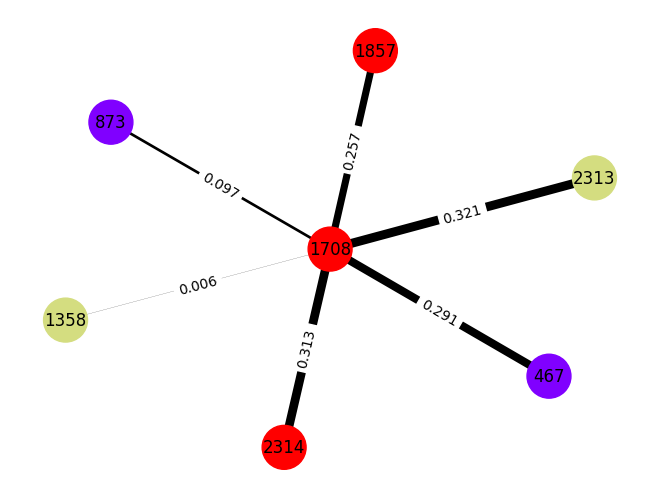

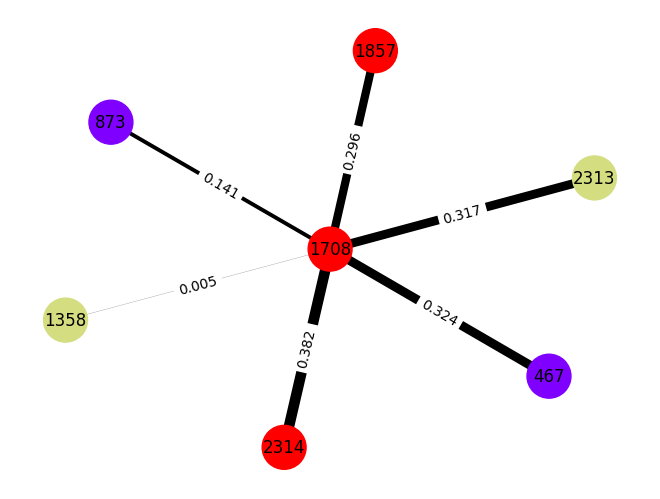

{1708: array([ 0.00064904, -0.00012374]),
 467: array([ 0.78361655, -0.64064944]),
 873: array([-0.78344498,  0.63940331]),
 1358: array([-0.94580937, -0.35795766]),
 1857: array([0.16252855, 1.        ]),
 2313: array([0.94632127, 0.3585909 ]),
 2314: array([-0.16386105, -0.99926337])}

In [20]:
def visualize_attention(node_id, data, edge_index, attention_weights, ax=None, pos=None):

    # Create a graph and add main node
    G = nx.Graph()
    G.add_node(node_id, color='red')

    # Add one-hop neighbors
    neighbors = edge_index[1][edge_index[0] == node_id].tolist()
    for neighbor in neighbors:
        G.add_edge(node_id, neighbor)

    # Get attention weights corresponding to the node and its neighbors
    indices = (edge_index[0] == node_id).nonzero().squeeze()

    node_attention_weights = attention_weights[indices.tolist()].squeeze().numpy()
    node_sizes = [1000 if n == node_id else 1000 for n in G.nodes()]


    edge_labels = {}
    for i, neighbor in enumerate(neighbors):
        edge_labels[(node_id, neighbor)] = round(node_attention_weights[i], 3)

    # Draw the graph
    if pos is None:
        pos = nx.spring_layout(G)

    nx.draw(G, pos, ax=ax, with_labels=True,
            node_color=[data.y[n].item() for n in G.nodes()],
            cmap=plt.cm.rainbow,
            node_size=node_sizes,
            width=node_attention_weights*20)


    nx.draw_networkx_edge_labels(
        G, pos,
        ax=ax,
        edge_labels=edge_labels,
        font_color='black'
    )

    plt.show()

    return pos

# Sample a node from test set and visualize
sampled_node = data.test_mask.nonzero().squeeze()[0].item()

# Compute the position once and reuse it
node_pos = visualize_attention(sampled_node, data, data.edge_index, avg_alpha1)
visualize_attention(sampled_node, data, data.edge_index, avg_alpha2, pos=node_pos)
